# CORONARY SYNTAX DATASET ANALYSIS

In [1]:
import cv2
import json
import numpy as np
from collections import defaultdict
import scipy
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load in the images
with open("arcade/syntax/val/annotations/val.json", encoding="utf-8") as file:
    gt = json.load(file)

path = "arcade/syntax/val/images/"
valstore = {}

for img in gt["images"]:
    image = cv2.imread(path + img['file_name'])
    valstore[img["id"]] = np.array(image)

In [3]:
# Adapted from https://github.com/cmctec/ARCADE/blob/main/useful%20scripts/create_masks.ipynb
cat_ids=[]
points_store=defaultdict(list)
gt_mask = np.zeros((300, 26, 512, 512), dtype=np.uint8)  # Use uint8 for binary mask
for ann in gt["annotations"]:
    #get points
    points = np.array([ann["segmentation"][0][::2], ann["segmentation"][0][1::2]], dtype=np.int32).T
    points_store[ann["image_id"], ann["category_id"]].append(points)

    #fill mask shape
    points = points.reshape((-1, 1, 2))
    tmp = np.zeros((512, 512), dtype=np.uint8)
    cv2.fillPoly(tmp, [points], (1))
    # binary mask
    gt_mask[ann["image_id"], ann["category_id"]] |= tmp
    #also store category ids useful for class analysis later in notebook
    cat_ids.append(ann["category_id"])

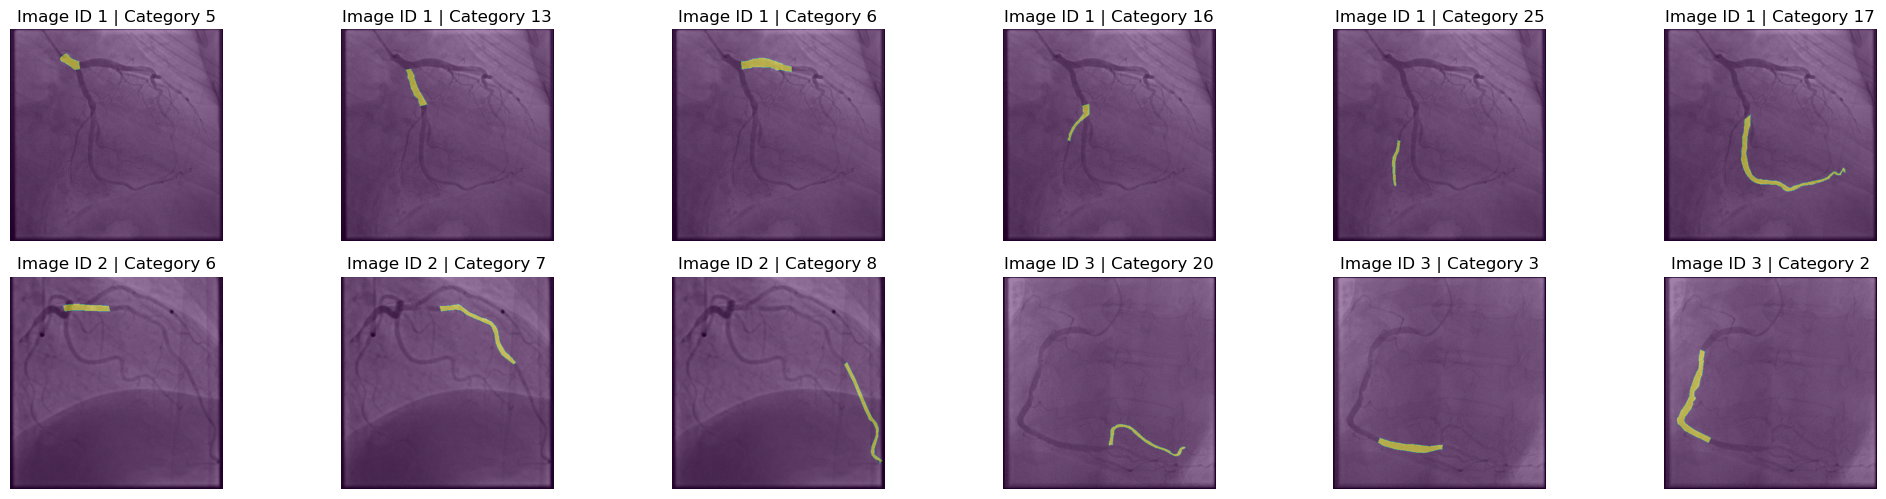

In [4]:
plt.figure(figsize=(20, 15))
for idx, ann in enumerate(gt["annotations"][:12]):
    ax = plt.subplot(6, 6, idx + 1)
    plt.imshow(valstore[ann['image_id']]) #plot img
    plt.imshow(gt_mask[ann["image_id"], ann["category_id"]], alpha=0.5) #plot annotation(s)
    plt.title(f"Image ID {ann['image_id']} | Category {ann['category_id']}")
    plt.axis('off')

plt.tight_layout()
plt.show()


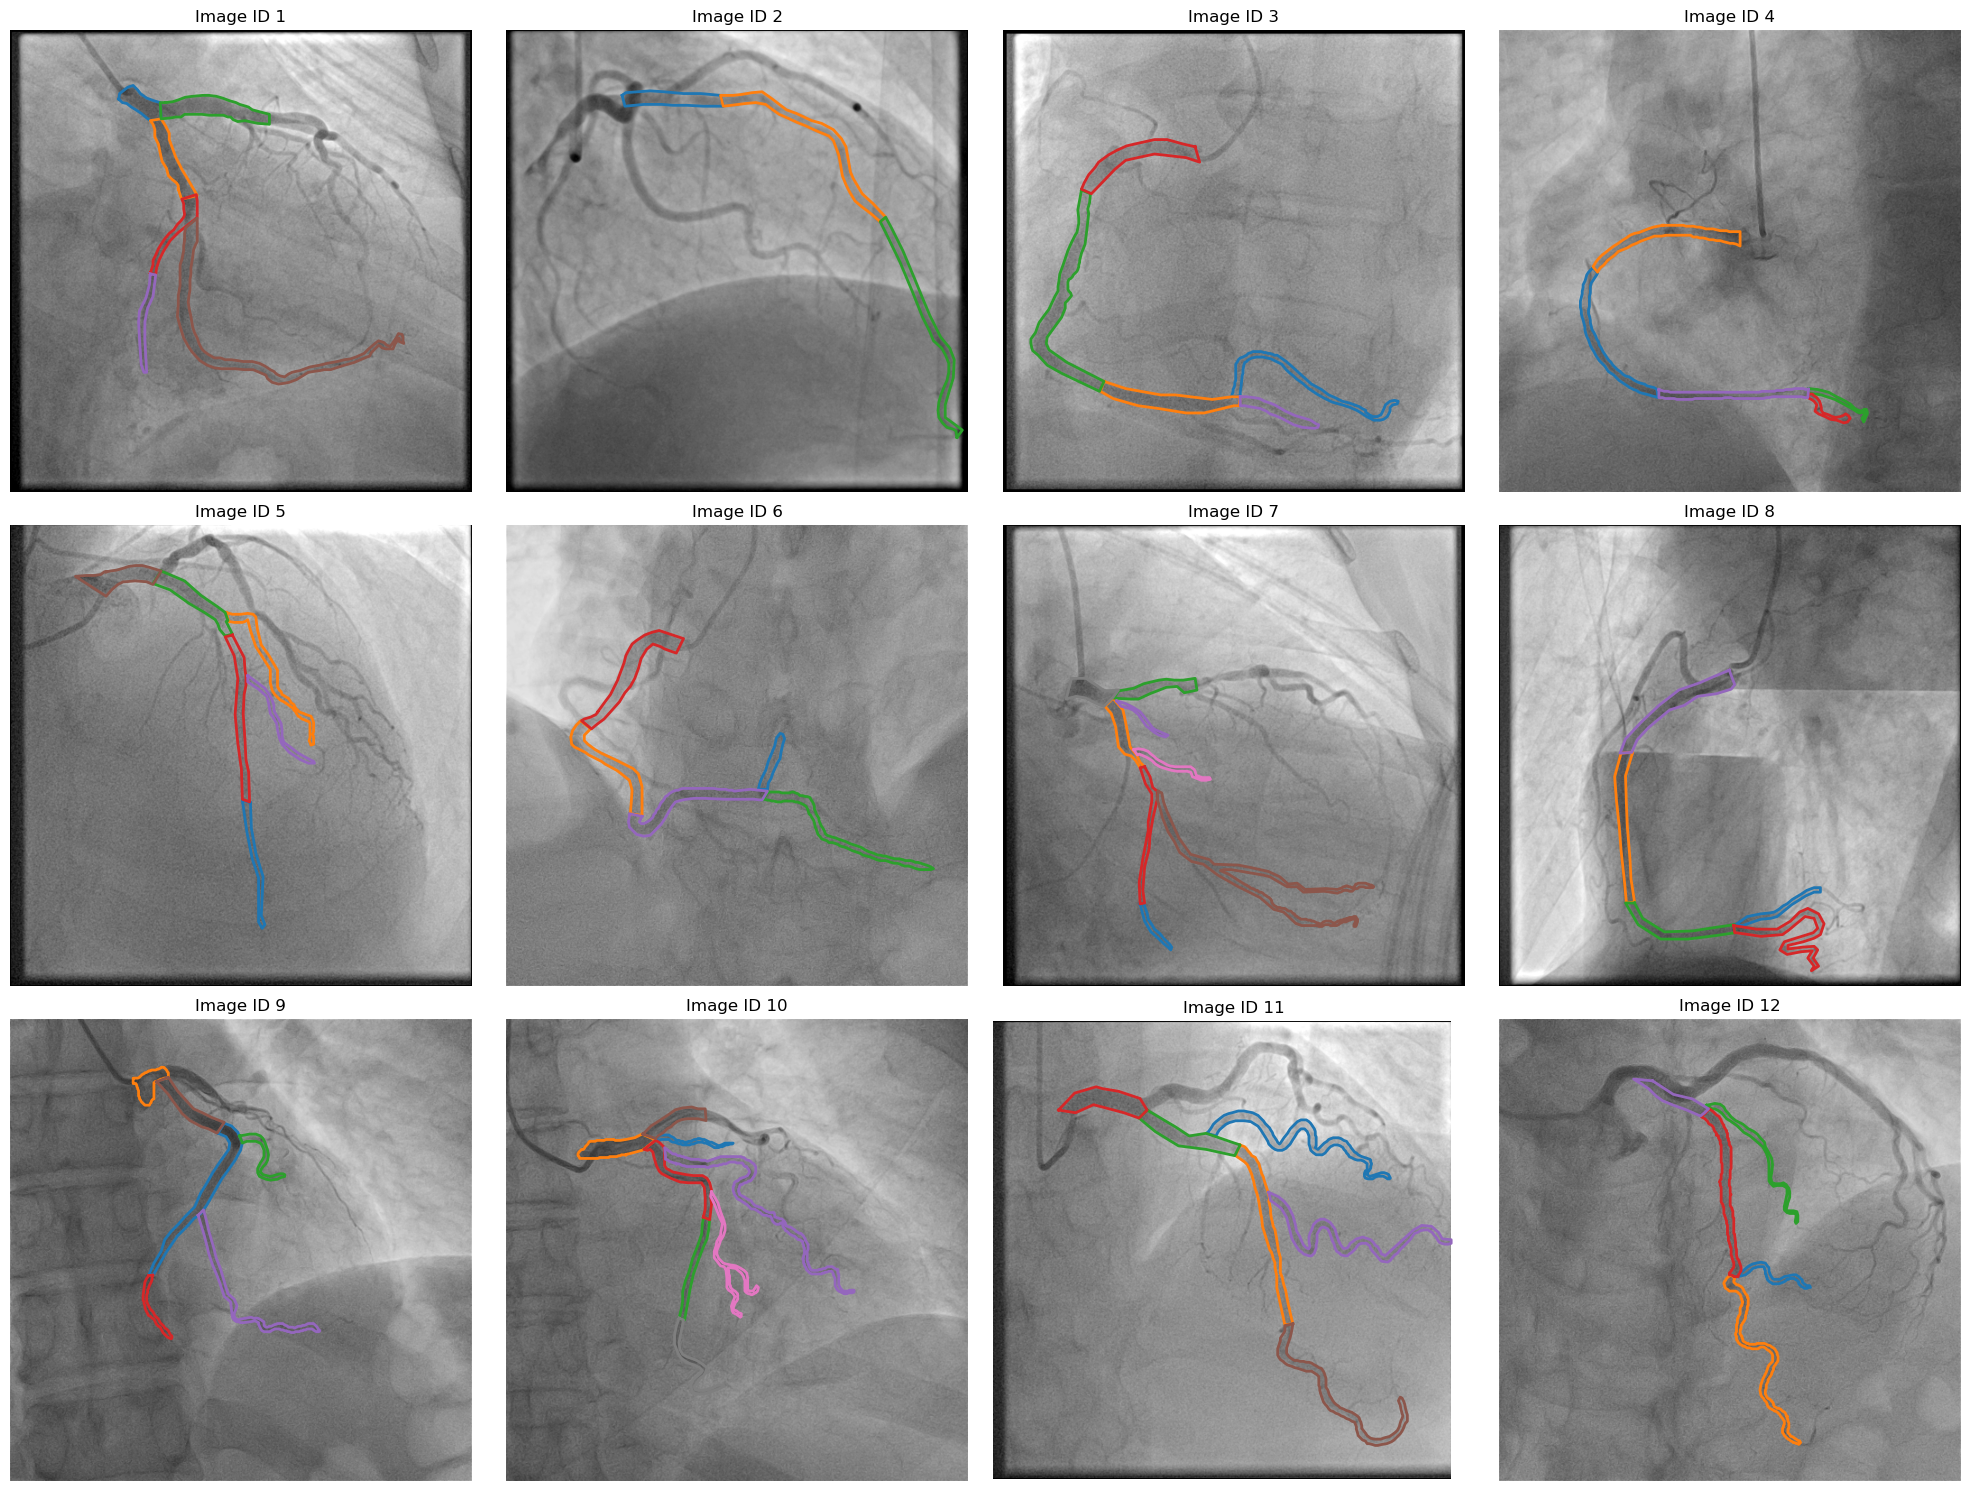

In [ ]:
plt.figure(figsize=(20, 15))
for idx, image_id in enumerate(range(1,13)):
    ax = plt.subplot(6, 6, idx + 1)
    plt.imshow(valstore[image_id])
    
    # Draw all polygons for this image
    for (img_id, cat_id), points_list in points_store.items():
        if img_id == image_id:
            for poly in points_list:
                poly = np.vstack([poly, poly[0]])  # close the polygon
                plt.plot(poly[:, 0], poly[:, 1], linewidth=2)  # outline

    plt.title(f"Image ID {image_id}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Intensity properties segment/background
def calc_intensity_properties(arr):
    max = np.max(arr)
    mean = np.mean(arr)
    median = np.median(arr)
    min = np.min(arr)
    std = np.std(arr)
    return {'max':max, 'min':min, 'mean':mean, 'median':median, 'std':std}

fimgs,bimgs=[],[]
for ann in gt["annotations"]:
    image = np.array(valstore[ann['image_id']]) 
    mask = np.array(gt_mask[ann['image_id'], ann["category_id"]])
    fimgs.append(image[mask==1])
    bimgs.append(image[mask==0])

#flatten imgs and concatenate into one array
fimgs = np.concatenate([fg.flatten() for fg in fimgs])
bimgs = np.concatenate([bg.flatten() for bg in bimgs])

#statistics 
propertiesf = calc_intensity_properties(fimgs)
propertiesb = calc_intensity_properties(bimgs)

stats = pd.DataFrame({'Segment':propertiesf, 'Background':propertiesb})
stats = stats.applymap(lambda x: round(x, 2))
stats

,Segment,Background
max,244.00,255.00
min,0.00,0.00
mean,116.06,135.09
median,114.00,132.00
std,28.24,42.80


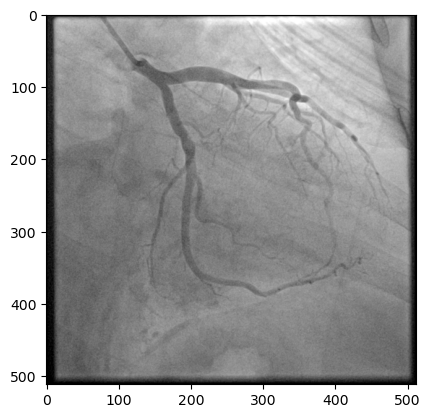

In [7]:
from Preprocess import preprocess

image = np.array(valstore[1])
plt.imshow(image)

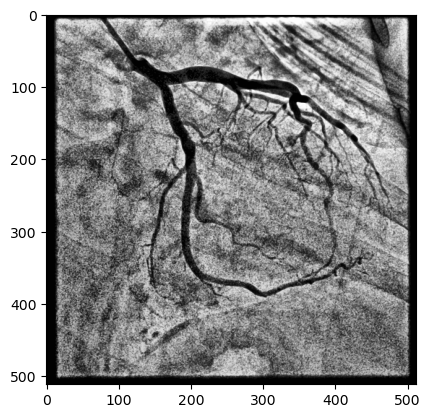

In [8]:
preprocessed = preprocess(image)
plt.imshow(preprocessed, cmap='grey')

In [13]:
mask = np.any(gt_mask[1], axis=0).astype(np.uint8) 
f = image[mask==1]
b = image[mask==0]
#statistics 
propertiesf = calc_intensity_properties(f)
propertiesb = calc_intensity_properties(b)

stats = pd.DataFrame({'Segment':propertiesf, 'Background':propertiesb})
stats = stats.applymap(lambda x: round(x, 2))
stats

,Segment,Background
max,196.00,255.00
min,60.00,0.00
mean,112.98,136.04
median,111.00,136.00
std,15.80,39.80


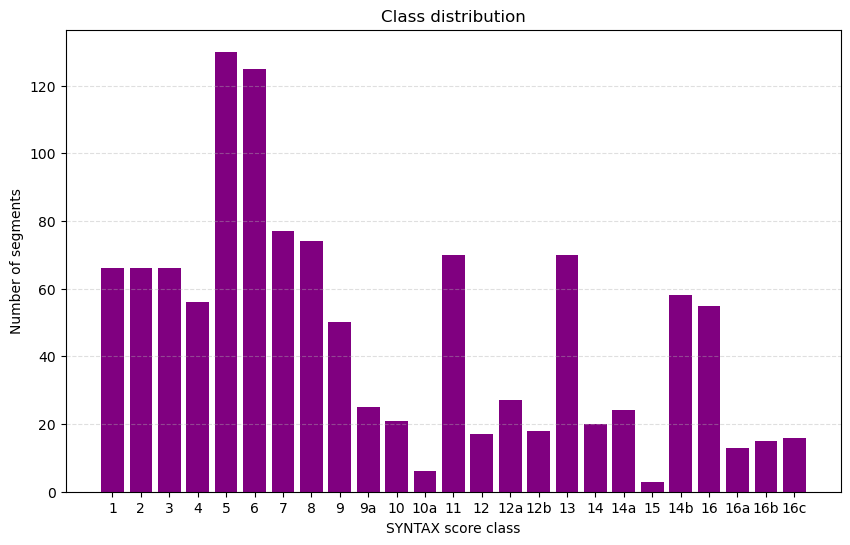

In [9]:
# Class distribution analysis
def calc_pct(pct, allvars):
    absolute = int(np.round(pct/100.*np.sum(allvars)))
    return f"{pct:.1f}%\n({absolute:d})"

def orderarray(arr, fromIdx, toIdx):
    element = arr[fromIdx]
    arr.pop(fromIdx)
    arr.insert(toIdx, element)

#get labels and class counts
class_names, class_counts=np.unique(cat_ids, return_counts=True)
class_counts=class_counts.tolist()

labels=[]
for data in gt['categories']:
    labels.append(data['name'])
labels=labels[:-1]

#re order
for arr in [labels, class_counts]:
    orderarray(arr,-1,19)
    orderarray(arr,-1,15)

#plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x=class_names, height=class_counts, tick_label=labels, color='purple')
ax.set(title=f'Class distribution', ylabel= 'Number of segments', xlabel='SYNTAX score class')
ax.grid(alpha=0.4, linestyle='--', axis='y')
plt.show()